# Baroclininic modes and their energy partitioning

In [ ]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load the mooring data
mooring_data = io.loadmat('/ArcticMooring.mat')
print(list(mooring_data.keys()))

['__header__', '__version__', '__globals__', 'U', 'rho', 'z']


In [ ]:
U_values = mooring_data['U'].flatten()
rho_values = mooring_data['rho'].flatten()
z_values = mooring_data['z'].flatten()

**(a) Write down the eigenvalue problem that gives rise to the baroclining mode decomposition of the QG stream function in the z-direction. Include the boundary conditions at the top and the bottom of the ocean. Recall that the stretching term has two z-derivatives.**
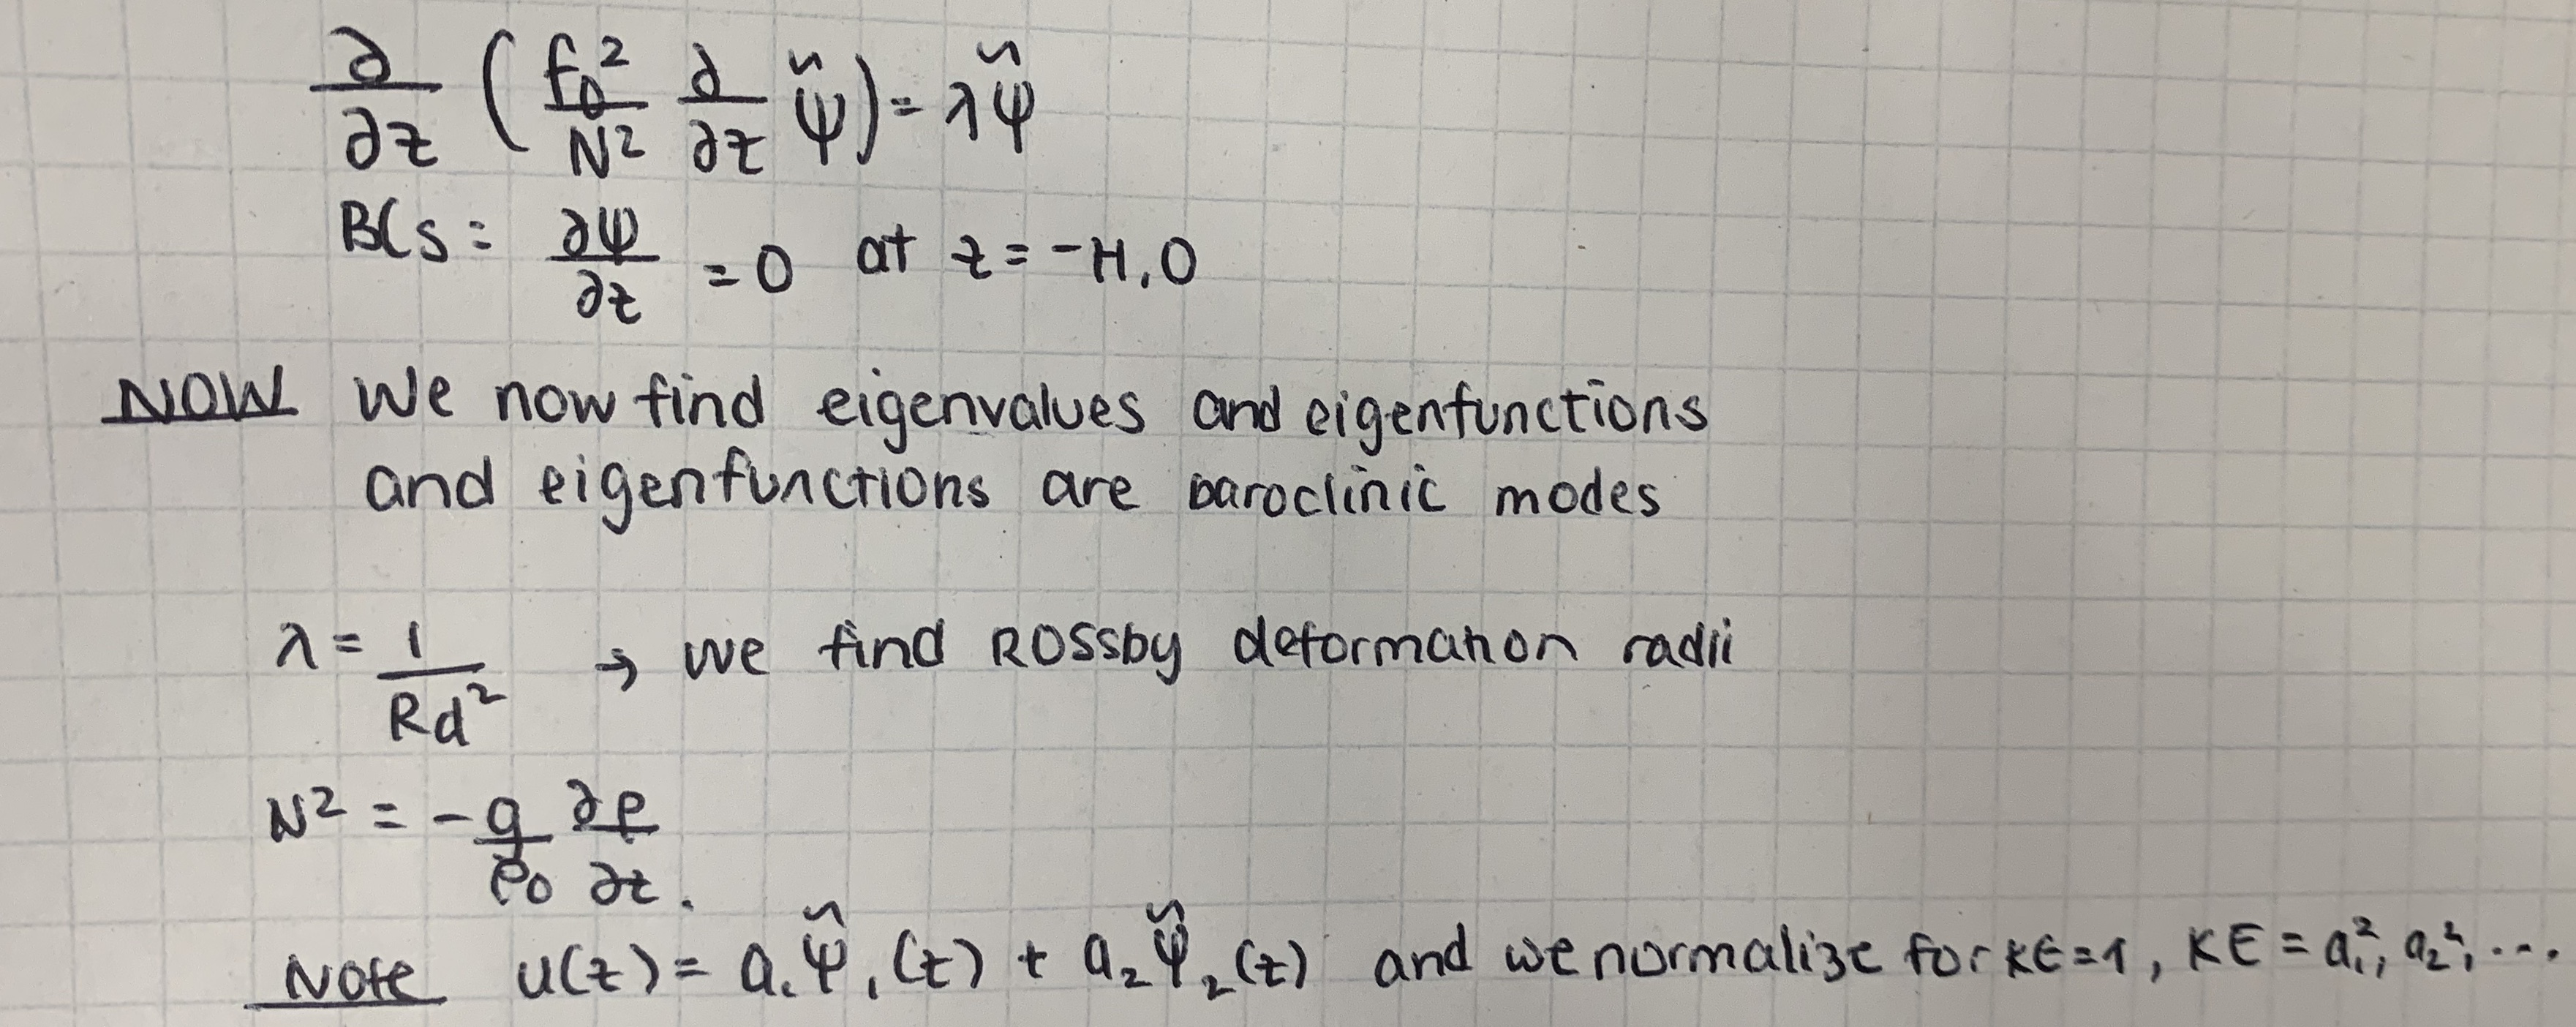

**(b) Assuming that the density profile rho(z) is given at discrete uniformly spaced depth levels z_i, where the index i denotes the depth level, use the finite different method to calculate the buoyancy frequency N_squared at a depth point z_(i+0.5) which is the midpoint between z_i and z_(i+1). Plot the vertical profile of N_squared(z).**

In [ ]:
g = 9.8 #m/s2
rho_0 = 1025

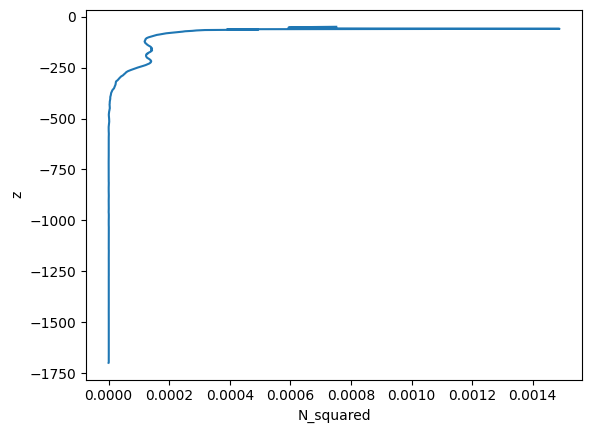

In [ ]:
del_z = np.abs(z_values[1]-z_values[0])

delrho_delz = np.zeros(len(rho_values)) # this is delrho_delz at (i + 0.5)
for i in range(len(rho_values)-1):
  delrho_delz[i] = (rho_values[i] - rho_values[i+1])/del_z

N_squared = (-g/rho_0)*delrho_delz # this is N_squared at a depth point z_(i+0.5)

plt.ylabel('z')
plt.xlabel('N_squared')
plt.plot(N_squared,z_values+0.5, )
plt.show()

**(c) Discretize the continuous eigenvalue equation using a finite-difference method to represent derivatives in the z-direction and down the eigenequation for the i-th depth level. Assume that the stream function psi(z) is defined at the same uniformly spaced vertical levels z_i, i.e. psi_i = psi(z_i).**

In [ ]:
delrho_delz_iminhalf = np.zeros(len(rho_values))
delrho_delz_iplushalf = np.zeros(len(rho_values))

for i in range(len(rho_values)-1):
  delrho_delz_iminhalf[i] = (rho_values[i-1] - rho_values[i])/del_z
  delrho_delz_iplushalf[i] = (rho_values[i] - rho_values[i+1])/del_z

N_squared_iminhalf = (-g/rho_0)*delrho_delz_iminhalf
N_squared_iplushalf = (-g/rho_0)*delrho_delz_iplushalf

In [ ]:
f0 = 1e-4
f0_squared = f0*f0

matrix_A = np.zeros((826,826))

i_min1 = ((f0_squared/N_squared_iminhalf)/del_z)/del_z
i_plus1 = ((f0_squared/N_squared_iplushalf)/del_z)/del_z
i_ati = (-((f0_squared/N_squared_iminhalf)/del_z) - ((f0_squared/N_squared_iplushalf)/del_z))/del_z

print(len(i_min1))
print(len(i_plus1))
print(len(i_ati))

826
826
826


<ipython-input-78-7fbc922424c0>:6: RuntimeWarning: divide by zero encountered in true_divide
  i_min1 = ((f0_squared/N_squared_iminhalf)/del_z)/del_z
<ipython-input-78-7fbc922424c0>:7: RuntimeWarning: divide by zero encountered in true_divide
  i_plus1 = ((f0_squared/N_squared_iplushalf)/del_z)/del_z
<ipython-input-78-7fbc922424c0>:8: RuntimeWarning: divide by zero encountered in true_divide
  i_ati = (-((f0_squared/N_squared_iminhalf)/del_z) - ((f0_squared/N_squared_iplushalf)/del_z))/del_z


In [ ]:
nz = len(z_values)

for i in range(1,nz-1):
  matrix_A[i,i] = i_ati[i]
  matrix_A[i,i-1] = i_min1[i]
  matrix_A[i,i+1] = i_plus1[i]

# now everything is filled except the top row and the bottom row

**(d) Note how for the very first and last depth points, you need information outside the z-domain to discretize the eigenvalue equation. This is where the boundary conditions come in: use the discretized version of the boundary conditions to write down the discretized eigenvalue equation for depths z_1 and z_N.**

In [ ]:
# Note that we have not filled the first and last row of matrix A
i_ati_top = (-(f0_squared/N_squared_iplushalf[0])/del_z)/del_z
i_plus1_top = ((f0_squared/N_squared_iplushalf[0])/del_z)/del_z

i_ati_bottom = (-(f0_squared/N_squared_iminhalf[-2])/del_z)/del_z # should have been the last element but I used second to last
i_min1_bottom = ((f0_squared/N_squared_iminhalf[-2])/del_z)/del_z

**(e) Express the discretized eigenvalue problem in a matrix form: A*psi = lambda*psi, where the matrix A is of size (N,N) and psi is a vector of length N.**

In [ ]:
matrix_A[0,0] = i_ati_top
matrix_A[0,1] = i_plus1_top
matrix_A[-1,-1] = i_ati_bottom
matrix_A[-1,-2] = i_min1_bottom

# from (c), (d) and (e) we have expressed the discretized eigenvalue problem in matrix form: A*psi = lambda*psi
print(matrix_A.shape)

(826, 826)


**(f) Using the density profile from the mooring (provided), calculate numerically the eigenvalues and eigenvectors of the matrix A.**

In [ ]:
eigenvals, eigenvecs = np.linalg.eig(matrix_A)

# eigenvals # all eigenvalues should be negative check again
Rd = np.real(np.sqrt(-1/eigenvals))

# sort everything by deformation radius from largest to smallest (sort eigenvals and also sort eigenvecs with the same indices)
sorted_arg_Rd_ind = np.argsort(Rd)[::-1][:826]

sorted_eigenvecs = eigenvecs[:,sorted_arg_Rd_ind]

print(np.sum(sorted_eigenvecs[:,0]**2)) # sanity check should be 1

1.0


<ipython-input-84-c7088dc99050>:4: RuntimeWarning: invalid value encountered in sqrt
  Rd = np.real(np.sqrt(-1/eigenvals))


**(g) Using the computed eigenvalues lambda, calculate the corresponding Rossby deformation radii for each baroclininc mode as Rd_i = sqrt(-1/lambda_i). There will be a small imaginary component due to numerical error, but you can remove it by taking the real part of Rd. If you sort Rd from large to small, the largest Rd would correspond to the barotropic deformation radius, which is effectively infinite, and the rest would correspond to baroclinic modes. Be careful when you sort the eigenvalues to also sort the corresponding eigenvectors. Use a bar plot to plot the deformation radii for the first 10 modes.**

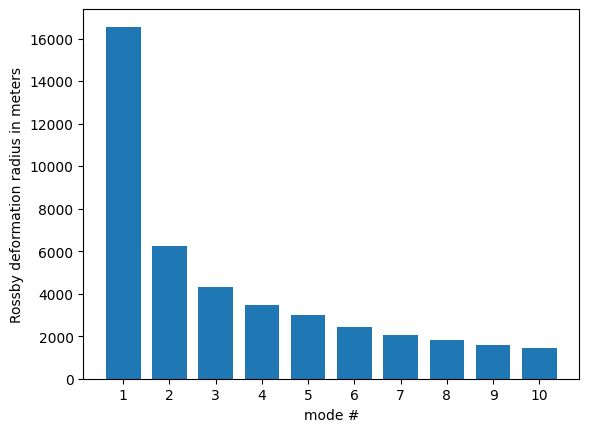

In [ ]:
sorted_Rd = Rd[sorted_arg_Rd_ind]

plt.bar(np.arange(10), np.real(sorted_Rd[1:11]), 0.75)
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10])
plt.xlabel('mode #')
plt.ylabel('Rossby deformation radius in meters')

plt.show()

**(h) The eigenvectors corresponding to the eigenvalues represent the vertical profiles of the baroclininc modes (each eigenvector is a column of the eigenvector matrix). Plot the barotropic and the first 3 baroclininc modes all together on the same panel.**

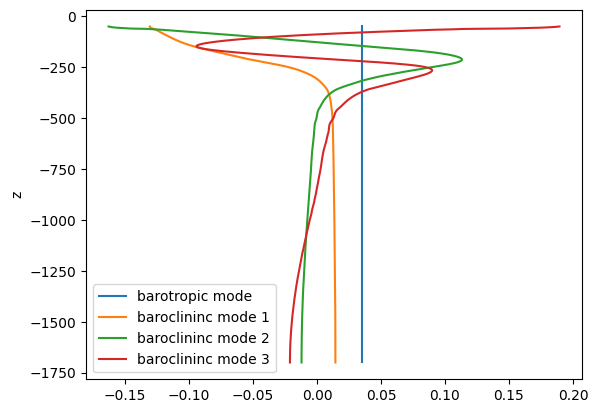

In [ ]:
plt.plot(sorted_eigenvecs[:,0], z_values, label='barotropic mode')
plt.plot(sorted_eigenvecs[:,1], z_values, label='baroclininc mode 1')
plt.plot(sorted_eigenvecs[:,2], z_values, label='baroclininc mode 2')
plt.plot(sorted_eigenvecs[:,3], z_values, label='baroclininc mode 3')
plt.legend()
plt.ylabel('z')
# what is the x label and units?

plt.show()

**(i) The vertical profile of the horizontal velocity U(z) into a sum of contributions from each mode as U(z) = summation a_i dot psi_i(z), where the amplitudes a_i = U*psi_i(z) which is the dot product between the velocity profile and the baroclinic mode profile. The kinetic energy corresponding to each baroclinic mode contribution is simply the square of its amplitude a_i_squared. For the given mean flow profile, calculate the energy contributions from the barotropic and baroclininc modes and use a bar chart to plot their magnitudes.**

In [ ]:
U_z_ls = np.zeros((826,826))
a_i_matrix = np.zeros(826)

for i in range(826):
  a_i = np.dot(U_values,sorted_eigenvecs[:,i]) # baroclinic mode profile
  a_i_matrix[i] = a_i
  U_z_i = a_i*sorted_eigenvecs[:,i]
  U_z_ls[i] = U_z_i

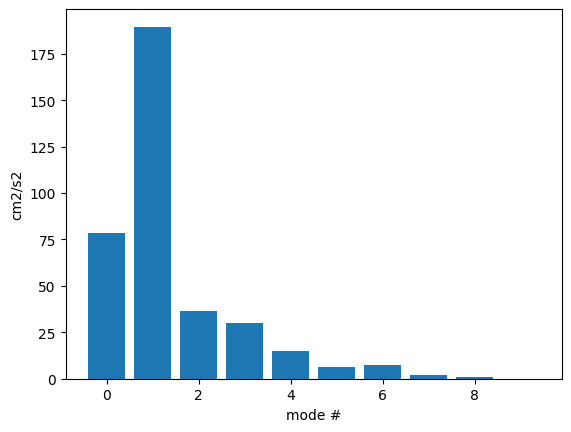

In [ ]:
KE = a_i_matrix**2
plt.bar(np.arange(10), KE[0:10]) # in cm2/s2
plt.ylabel('cm2/s2')
plt.xlabel('mode #')
plt.show()